## R(t)

Esto es relativamente viejo
Último update: 2022.10.22

Calculo el radio en función del tiempo usando la ecuación 2.2.1.1 de la tesis de Gabriela  
1. A través del cambio de variables R = R, v_R = R', transformo la ecuación diferencial de orden 2 en dos ecuaciones diferenciales de orden 1
2. Me armo el sistema dy/dt = f(y,t) donde y = (R, v_R) y resuelvo la ecuación numéricamente
(El desarrollo de las ecuaciones está en el cuadernillo)

Comentarios:  
* La dependencia de la presión de la burbuja p_B está dada por la presión eléctrica p_e del paper de Bunkin
* La dependencia de la masa m(t) se asume conocida pero realmente habría que estimarla usando el problema de reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente.
* Las fórmulas del paper están en el sistema CGS, así que expreso todo en esas unidades

DUDAS:
* Estoy considerando rho_L_inf = rho_L_i, está bien?
* Estoy tomando x_max = 6 (aproximación del paper antes de la ec. (18)), está bien?
* rho_Bunkin = rho_L_inf  o rho_L_i ? Estoy considerando a priori lo primero, está bien?
* u0 (mu) da igual que a lo que da la ec. 19a (19b)? Sí, da lo mismo. u0 da ligeramente distinto pero creo que puede deberse a que estoy tomando una densidad distinta.
* Estoy asumiendo que las ecuaciones de Bunkin están en el sistema MKS y por lo tanto los parámetros del problema están en MKS
* Verificar si T_e = Delta/3 siempre o cambia durante la evolución
* R0 = 1e-6 
* v_R0 = 0? condición inicial
* En la solución numérica se asumió que el problema no es stiff
* a_i = 2e-5 para nuestro problema? radio del electrolito
* l = 2*a_i #aproximación hecha en el Bunkin

In [59]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from math import pi

### Parámetros del problema
en sistema de unidades CGS:
https://es.wikipedia.org/wiki/Sistema_Cegesimal_de_Unidades

In [60]:
#En CGS:
#Parámetros de la ecuación diferencial
p_inf = 0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)
rho_L_i = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L_i = rho_L_i*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)
rho_L_inf = rho_L_i #densidad del líquido en el infinito. A priori considero rho_L_inf = rho_L_i

#Parámetros de la presión eléctrica p_e

#En CGS:
#Condiciones iniciales de la ecuación diferencial
Delta = 6 #Energía mecánica para arrancar un electrón de la pared en [eV]
T_e = Delta/3 #Temperatura de los electrones dentro de la burbuja en [eV]. Conversión: (ev)*()
T_e = T_e*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)
x_max = 6 #Esto es una aproximación considerada en el paper antes de la ec. (18)
q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

R0 = 1e-6 #Radio inicial de un bubston en [cm]. Este valor lo saqué del supuesto inicial del Bunkin


rho_Bunkin = rho_L_inf #densidad del líquido


In [61]:
def n_e_max_mean(T_e, q_e, R0):
    #densidad media máxima
    return (16/3)*T_e**2/(pi*q_e**4*R0)

def u0(T_e, q_e, R0):
    #Calculo u0 a partir de expresión (19a) del paper de Bunkin
    return np.sqrt( (2*x_max/9)*n_e_max_mean(T_e, q_e, R0)*T_e/rho_Bunkin )

def mu(T_e, q_e, R0):
    #Calculo mu a partir de expresión (19b) del paper de Bunkin
    return (8/(3*x_max))*((x_max-1)/x_max)**2*(T_e*R0/q_e**2)

In [62]:
#Verifico si obtengo los mismos valores
print("n_e_max_mean = ", n_e_max_mean)
print("u0 = ", u0)
print("mu = ", mu)

n_e_max_mean =  <function n_e_max_mean at 0x000001A9F3C63940>
u0 =  <function u0 at 0x000001A9F3C8F430>
mu =  <function mu at 0x000001A9F08A4940>


### Funciones de presión y masa

In [63]:
#Defino la función de masa y sus derivadas

#Asumo que a t = 0 hay N_H2O_0 partículas de agua vapor (es indistinto que sea vapor o líquido)
Na = 6.02214076e23 #Nro de Avogadro
m_H2O = 18/Na #Masa de una molécula de agua en [g]
N_H2O_0 = 1e3 #Nro de partículas de agua iniciales
m0 = N_H2O_0*m_H2O #Masa inicial

def m(t):
    # Dependencia de la masa en [g] en función del tiempo. 
    # A priori se asume que es conocida e igual a parábola de coeficientes alpha y m0 arbitrarios
    # Realmente habría que estimarla usando el problema reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente
    #Asumo que a t=0 la masa es m0 y a t=100 mu s la masa es 10*m0:
    alpha = 9*m0/(100e-6)**2
    return alpha*t**2 + m0

def mp(t):
    #Derivada de la masa en función del tiempo
    alpha = 9*m0/(100e-6)**2
    return 2*alpha*t

def mpp(t):
    #Segunda derivada de la masa en función del tiempo
    alpha = 9*m0/(100e-6)**2
    return 2*alpha

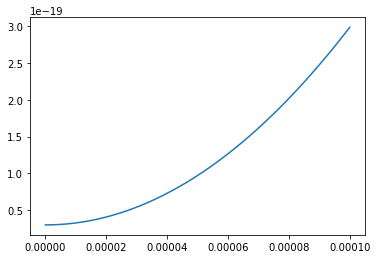

In [64]:
#Grafico m(t)
t = np.linspace(0, 100e-6, 1000)
plt.plot(t, m(t));

In [65]:
#Presión eléctrica del paper de Bunkin
def p_e(R, T_e, q_e, R0):
    #Presión eléctrica en [baria] (CGS) del paper de Bunkin ec. (24)
    #R: radio del bubston en cm
    return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4

def dpdt_e(R, v_R, T_e, q_e, R0):
    #Derivada de la presión eléctrica respecto a t en [baria/s] del paper de Bunkin
    #R: radio del bubston en cm
    dpdR_e = rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(-4/R0)*(R0/R)**5 #Derivada respecto al radio
    dpdt_e = dpdR_e*v_R #Derivada respecto al tiempo
    return dpdt_e

In [66]:
#Presión de las partículas de gas asumiendo comportamiento ideal (MODELO FENOMENOLOGICO)

def V(R):
    #Volumen de una esfera de radio R
    return (4/3)*pi*R**3

def dVdR(R):
    #Derivada del volumen de una esfera de radio R respecto a su radio
    return 4*pi*R**2

def p_GI(R):
    #Presión de las partículas de gas asumiendo comportamiento ideal en [baria] (CGS). Asumo que la temperatura corresponde a la del líquido en el infinito
    
    Tinf=35+273.15 #Esto lo usamos para calcular rho_L_i

    m_H20 = 18/Na #Masa de una partícula de H20 en [g]. Está en g porque m(R) también lo está
    N = m(R)/m_H20 #Nro de partículas

    K_B = 1.380649e-23 #cte de Boltzmann en [J/K]
    K_B = K_B/1e-7 #en [ergio/K]. Conversión: (J/K)*(1erg/10−7J)

    P = N * K_B * Tinf / V(R)
    return 0
    return P

def dpdt_GI(R, v_R):
    #Derivada de la presión del gas respecto al tiempo en [baria/s] (CGS)
    dpdR_GI = -p_GI(R)/V(R)*dVdR(R) #Derivada respecto al radio
    dpdt_GI = dpdR_GI*v_R #Derivada respecto al tiempo
    return 0
    return dpdt_GI


In [67]:
#Defino funciones de presión

def p_B(R,T_e, q_e, R0):
    #Presión de la burbuja. Se considera que es igual a la presión de eléctrica p_e del paper de Bunkin más una presión de GI. El objetivo de esta presión es verificar si tienen o no efecto las moléculas dentro del bubston.
    return p_e(R,T_e, q_e, R0) + p_GI(R)

def dpBdt(R, v_R,T_e, q_e, R0):
    #Derivada de la presión de la burbuja
    return dpdt_e(R, v_R,T_e, q_e, R0) + dpdt_GI(R, v_R)


### Sistema de ecuaciones diferenciales

In [68]:
#Defino el sistema de ecuaciones de primer orden

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Defino las ctes del sistema
    T_e_ = T_e
    q_e_ = q_e
    R0_ = R0

    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Expreso dydt_1 = d(v_R/dt) = d2(R)/dt2 
    term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R,T_e_, q_e_, R0_) - p_inf)
    term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    term5 = (R/c_L*rho_L_inf)*dpBdt(R, v_R,T_e_, q_e_, R0_)

    dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    return [dydt_0, dydt_1]


### Solución numérica

In [69]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 70e-9 #70 ns
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff


In [70]:
#Imprimo propiedades de la solución
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3758
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 8.21143770e-23, 9.03258147e-22, 9.11469585e-21,
       9.12290729e-20, 6.14179556e-19, 3.41386683e-18, 1.56829170e-17,
       5.75475377e-17, 1.79081778e-16, 5.80704156e-16, 1.91107959e-15,
       9.51894850e-15, 7.07435957e-14, 3.08136465e-13, 5.99689815e-13,
       9.45805786e-13, 1.41600235e-12, 1.76983397e-12, 2.12366559e-12,
       2.37750501e-12, 2.63134444e-12, 2.94283450e-12, 3.31092985e-12,
       3.74062829e-12, 4.26938544e-12, 4.89226705e-12, 5.51514866e-12,
       6.09422638e-12, 6.66813661e-12, 7.25387998e-12, 7.86004100e-12,
       8.49295093e-12, 9.15812415e-12, 9.86085231e-12, 1.06066499e-11,
       1.14012277e-11, 1.22507251e-11, 1.31618715e-11, 1.41421132e-11,
       1.51997406e-11, 1.63440150e-11, 1.75852877e-11, 1.89350950e-11,
       2.04062065e-11, 2.20125839e-11, 

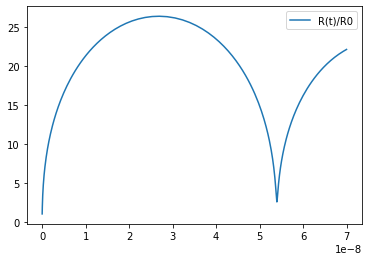

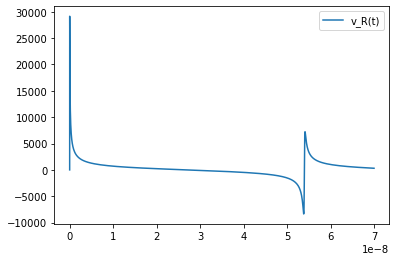

C:\Users\lupam\AppData\Local\Temp\ipykernel_5076\3442091702.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4
C:\Users\lupam\AppData\Local\Temp\ipykernel_5076\2798353852.py:22: RuntimeWarning: divide by zero encountered in true_divide
  P = N * K_B * Tinf / V(R)


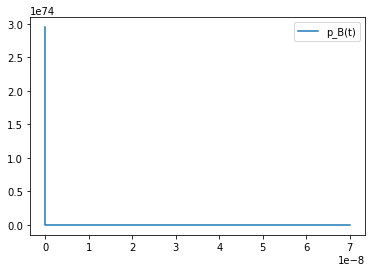

In [71]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, p_B(sol.t,T_e, q_e, R0), label = "p_B(t)")
plt.legend()
plt.show()


### Verificación

Según el paper de Bunkin, a t = t_coal debe ocurrir que R = R1, ambos parámetros bien definidos
Supongamos por lo pronto que m = 0 para todo tiempo, asumiendo que la masa de los electrones entrantes, que son los responsables de la expansión inicial, es despreciable

In [72]:
a_i = 2e-5 #radio de Debye de un ion electrolito en un líquido. En este caso el agua (valor sacado del Bunkin) en [cm]
t_coal = ( 2/5*(R0/u0(T_e, q_e, R0)) )/np.sqrt(2*(1 + 2*mu(T_e, q_e, R0)))*(a_i/R0)**(5/2) #tiempo de coalescencia en [s] (creo)
l = 2*a_i #aproximación hecha en el Bunkin*
R1 = l/2 #radio del bubston necesario para que las burbujas se toquen

print("tiempo de coalescencia (t_coal): ", t_coal)
print("radio relativo teórico del bubston en t = t_coal (R1/R0): ", R1/R0)

tiempo de coalescencia (t_coal):  4.584739171374519e-09
radio relativo teórico del bubston en t = t_coal (R1/R0):  20.000000000000004


In [73]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = t_coal
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff

print("radio numérico del bubston en t = t_coal (R1): ", sol.y[0][-1]/R0)


radio numérico del bubston en t = t_coal (R1):  16.028292831866146


#### Consideraciones
Encontré que el resultado es independiente de si m(t) = 0 o no. Esto tiene sentido porque m(t) hace referencia a los iones/moléculas de dentro y según el paper de Bunkin no tienen efecto inicialmente tales partículas. Habría que verificar esto formalmente poniendo una presión debido a tales partículas, por ejemplo debido a un GI.

A continuación se detallan el radio del bubston en t = t_coal(R1) considerando o no la masa y la presión de las partículas:
* m = 0, p_GI = 0: 16.028292831866146
* m!= 0 (N_H2O_0 = 1e9), p_GI = 0: 16.028292831866146
* m!= 0 (N_H2O_0 = 1e9), p_GI!= 0: 81.30913083691735 
CAMBIA CONSIDERABLEMENTE! Quizás el problema está en la cantidad de partículas consideradas. Gustavo me había dicho que el nro de partículas iniciales era despreciable respecto al nro de electrones máximos
* m!= 0 (N_H2O_0 = 1e3), p_GI!= 0: 81.30913083691735 
Tal cantidad de partículas de vapor implicaría una presión de 10 atm (p_GI(R0)*0.1*9.86923e-6
) dentro de la burbuja. Es exagerado? Sí, pero con 109 partículas tengo 107 atm....




Los nros siguientes los obtuve haciendo mal la cuenta. Había considerado que dpdt = dpdR y no es así
* m != 0, p_GI = 0: 19.185427198440635
* m = 0, p_GI = 0: 19.185427198440635
* m != 0, p_GI != 0:

## Formación de burbuja a partir del cluster

1. Calculamos el tiempo tal que R = R1
2. Supongo que a ese tiempo, instantáneamente se forma una burbuja con todos los bubston del cluster, de tamaño n_bubston*R1
3. Calculo la evolución de la nueva burbuja considerando tmb que hay una carga de n_bubston*e
4. Ver el efecto de considerar o no una presión de gas p_GI

Durante la evolución estoy asumiendo Te constante aunque no sea así necesariamente. También asumí que la carga "inicial" es q_e*n_bubston.

In [78]:
#Defino el sistema de ecuaciones diferenciales. La diferencia con el anterior es el radio inicial y la carga contenida
n_bubston = 1e8


def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Defino las ctes del sistema
    T_e_ = 0.1*(1.602176565e-19)*(1/1e-7)
    R0_ = R1*n_bubston
    q_e_ = q_e*n_bubston #NO SÉ SI ESTO ESTÁ BIEN

    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Expreso dydt_1 = d(v_R/dt) = d2(R)/dt2 
    term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R,T_e_, q_e_, R0_) - p_inf)
    term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    term5 = (R/c_L*rho_L_inf)*dpBdt(R, v_R,T_e_, q_e_, R0_)

    dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    return [dydt_0, dydt_1]

In [79]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 2 #2.5e-6 #70 ns
R_cl = 0.02 #cm
y_ini = [R_cl, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff

print(sol)

  message: 'Required step size is less than spacing between numbers.'
     nfev: 4850
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 4.61003521e-10, 2.59124924e-09, 9.72696413e-09,
       3.52699671e-08, 2.42025524e-07, 1.56878579e-06, 2.89538741e-06,
       4.13800462e-06, 5.32201516e-06, 6.44594880e-06, 7.50545673e-06,
       8.49799567e-06, 9.42315285e-06, 1.02821718e-05, 1.10774140e-05,
       1.18119263e-05, 1.24891295e-05, 1.31126069e-05, 1.36859640e-05,
       1.42127384e-05, 1.46963427e-05, 1.51400306e-05, 1.55468778e-05,
       1.59197735e-05, 1.62614182e-05, 1.65743270e-05, 1.68608347e-05,
       1.71231039e-05, 1.73631338e-05, 1.75827691e-05, 1.77837100e-05,
       1.79675216e-05, 1.81356431e-05, 1.82893972e-05, 1.84299984e-05,
       1.85585610e-05, 1.86761074e-05, 1.87835745e-05, 1.88818213e-05,
       1.89716344e-05, 1.90537344e-05, 1.91287808e-05, 1.91973777e-05,
       1.92600775e-05, 1.93173859e-05, 1.93697654

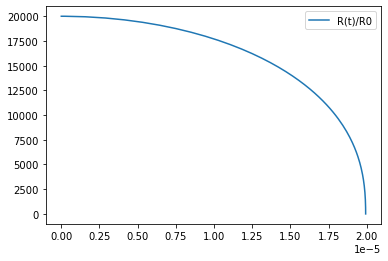

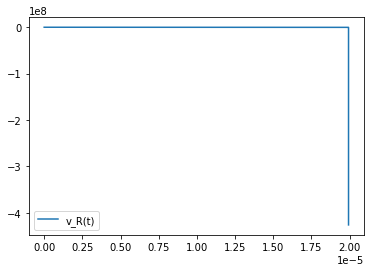

C:\Users\lupam\AppData\Local\Temp\ipykernel_5076\3442091702.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4
C:\Users\lupam\AppData\Local\Temp\ipykernel_5076\2798353852.py:22: RuntimeWarning: divide by zero encountered in true_divide
  P = N * K_B * Tinf / V(R)


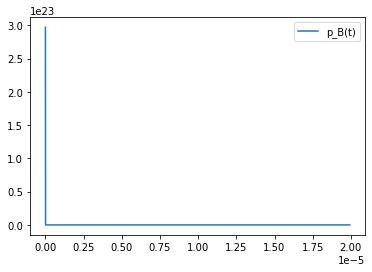

In [80]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, p_B(sol.t,T_e, q_e, R0), label = "p_B(t)")
plt.legend()
plt.show()


### Consideraciones
* A tal tamaño y tal cantidad de cargas la burbuja comienza a decrecer en tamaño. Esto es lo que se obtiene en el papaer?
* Con n_bubston = 10e2, a t = 2e-6 s aproximadamente se llega al mínimo. Esto ocurre independientemente de la presión producida por el GI en el interior. Luego de que la burbuja llega al cero, se produce un comportamiento oscilatorio en el que se genera una nueva burbuja y así sucesivamente.
* Con n_bubston = 10e8, el comportamiento anterior ocurre a los 2 s. Con el método numérico no puedo ejecutar el código para tiempos mayores, me da el error "Required step size is less than spacing between numbers". Según entiendo en ese punto hay una singularidad (infinito) en v_R que el solver no puede manejar
Cambié el radio del cluster. Antes estaba en 

In [77]:
70e2

7000.0